In [65]:
import sys
import dawis as d
import glob as glob
import os
import numpy as np
import pyregion as pyr
import random
import gc
import h5py
import dawis
import matplotlib as mpl
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.io import fits
from astropy.visualization import *
from scipy.stats import kurtosis
from power_ratio import *
from datetime import datetime
from photutils.segmentation import SourceCatalog, detect_sources
import make_results_ERO_noray
import tracemalloc
import matplotlib
import cmasher
from astropy.wcs import WCS
from scipy.ndimage import gaussian_filter
from matplotlib.patches import Rectangle
from astropy.stats import sigma_clip
import subprocess


In [30]:
# Paths, lists & variables
path_data = '/home/aellien/Euclid_ERO/data/Euclid-NISP-Stack-ERO-Abell2390.DR3'
path_scripts = '/home/aellien/Euclid_ERO/Euclid_ERO_scripts'
path_wavelets = '/home/aellien/Euclid_ERO/wavelets/out8/'
path_plots = '/home/aellien/Euclid_ERO/plots'
path_analysis = '/home/aellien/Euclid_ERO/analysis/'

In [26]:
# Make masks of all objects
hdu1 = fits.open(os.path.join(path_analysis, 'Abell_2390_NISP_mask_all_but_bcg_full_img_H.fits'))
m_all_but_bcg = hdu1[0].data
hdu2 = fits.open(os.path.join(path_analysis, 'Abell_2390_NISP_mask_all_but_clmembers_full_img_H.fits'))
m_all_but_clmembers = hdu2[0].data

m_all = np.copy(m_all_but_bcg.astype(bool))
m_all[np.where((m_all_but_clmembers.astype(bool) == False) & (m_all == True)) ] = False
m_all = m_all.astype(int)

hduo = fits.PrimaryHDU(m_all, header = hdu1[0].header) 
hduo.writeto(os.path.join(path_analysis, 'Abell_2390_NISP_mask_all_full_img_H.fits'))

In [89]:
# Apply mask & inpaint & preprocessing
for infile in glob.glob(os.path.join(path_data, 'Euclid-NISP-?-ERO-Abell2390-LSB.DR3.fits')):
    
    print(infile)
    filt = infile[-28]
    hdu = fits.open(os.path.join(path_data, infile))
    oim, header = hdu[0].data, hdu[0].header
    mask = fits.getdata(os.path.join(path_analysis, 'Abell_2390_NISP_mask_all_full_img_H.fits'))

    # mask
    moim = np.copy(oim)
    moim[~mask.astype(bool)] = np.nan

    # inpaint
    noise_pixels, val_max = dawis.sample_noise(moim, n_sigmas = 3, bins = 300)
    mean, std = np.mean(noise_pixels), np.std(noise_pixels)
    mask = np.zeros(moim.shape)
    mask[ moim < -abs(5 * std) ] = 1.
    mask[np.where(np.isnan(moim) == True)] = 1.
    draws = np.random.normal(mean, std, moim.shape)
    mask *= draws
    moim[ moim < -abs(5 * std) ] = 0.
    moim[ np.where(np.isnan(moim) == True)] = 0.
    moim += mask
    hduo = fits.PrimaryHDU(moim, header = header)
    hduo.writeto(os.path.join(path_data, 'Euclid-NISP-%s-ERO-Abell2390-LSB.DR3.masked.fits'%filt), overwrite = True)

    # rot
    masked = os.path.join(path_data, 'Euclid-NISP-%s-ERO-Abell2390-LSB.DR3.masked.fits'%filt)
    rot = os.path.join(path_data, 'Euclid-NISP-%s-ERO-Abell2390-LSB.DR3.masked.rot.fits'%filt)
    subprocess.run(['astwarp', '--rotate=295', '-h0', masked, '--output=%s'%rot])

    # crop
    crop = os.path.join(path_data, 'Euclid-NISP-%s-ERO-Abell2390-LSB.DR3.masked.rot.crop.fits'%filt)
    subprocess.run(['astcrop', '--mode=wcs', '--center=328.40009,17.699051', '--width=0.75,0.75', '-h1', '--output=%s'%crop, rot])

    # warp
    warp = os.path.join(path_data, 'Euclid-NISP-%s-ERO-Abell2390-LSB.DR3.masked.rot.crop.warp.fits'%filt)
    subprocess.run(['astwarp', '--scale=1./4.', '-h1', '--output=%s'%warp, crop])

    # dawis input rdy
    input = os.path.join(path_data, 'Euclid-NISP-%s-ERO-Abell2390-LSB.DR3.masked.rot.crop.warp.input.fits'%filt)
    subprocess.run(['astfits', warp, '--copy=1', '--output=%s'%input, '--primaryimghdu'])

print('done')

/home/aellien/Euclid_ERO/data/Euclid-NISP-Stack-ERO-Abell2390.DR3/Euclid-NISP-H-ERO-Abell2390-LSB.DR3.fits


Warp 0.21 started on Sun Jul 14 12:48:21 2024
 Using 20 CPU threads.
 Input: /home/aellien/Euclid_ERO/data/Euclid-NISP-Stack-ERO-Abell2390.DR3/Euclid-NISP-H-ERO-Abell2390-LSB.DR3.masked.fits (hdu: 0)
 matrix:
	 0.4226    0.9063    0.0000
	-0.9063    0.4226    0.0000
	 0.0000    0.0000    1.0000
 Output: /home/aellien/Euclid_ERO/data/Euclid-NISP-Stack-ERO-Abell2390.DR3/Euclid-NISP-H-ERO-Abell2390-LSB.DR3.masked.rot.fits
Warp finished in:  18.026429 seconds
Crop 0.21 started on Sun Jul 14 12:48:39 2024
  - Read metadata of 1 dataset.                        0.001318 seconds
  ---- ...SB.DR3.masked.rot.crop.fits created: 1 input.
Crop finished in:  1.197804 seconds
Warp 0.21 started on Sun Jul 14 12:48:40 2024
 Using 20 CPU threads.
 Input: /home/aellien/Euclid_ERO/data/Euclid-NISP-Stack-ERO-Abell2390.DR3/Euclid-NISP-H-ERO-Abell2390-LSB.DR3.masked.rot.crop.fits (hdu: 1)
 matrix:
	 0.2500    0.0000    0.0000
	 0.0000    0.2500    0.0000
	 0.0000    0.0000    1.0000
 Output: /home/aellien/Eu

Warp 0.21 started on Sun Jul 14 12:49:01 2024
 Using 20 CPU threads.
 Input: /home/aellien/Euclid_ERO/data/Euclid-NISP-Stack-ERO-Abell2390.DR3/Euclid-NISP-J-ERO-Abell2390-LSB.DR3.masked.fits (hdu: 0)
 matrix:
	 0.4226    0.9063    0.0000
	-0.9063    0.4226    0.0000
	 0.0000    0.0000    1.0000
 Output: /home/aellien/Euclid_ERO/data/Euclid-NISP-Stack-ERO-Abell2390.DR3/Euclid-NISP-J-ERO-Abell2390-LSB.DR3.masked.rot.fits
Warp finished in:  18.481371 seconds
Crop 0.21 started on Sun Jul 14 12:49:20 2024
  - Read metadata of 1 dataset.                        0.000885 seconds
  ---- ...SB.DR3.masked.rot.crop.fits created: 1 input.
Crop finished in:  1.109867 seconds
Warp 0.21 started on Sun Jul 14 12:49:21 2024
 Using 20 CPU threads.
 Input: /home/aellien/Euclid_ERO/data/Euclid-NISP-Stack-ERO-Abell2390.DR3/Euclid-NISP-J-ERO-Abell2390-LSB.DR3.masked.rot.crop.fits (hdu: 1)
 matrix:
	 0.2500    0.0000    0.0000
	 0.0000    0.2500    0.0000
	 0.0000    0.0000    1.0000
 Output: /home/aellien/Eu

Warp 0.21 started on Sun Jul 14 12:49:42 2024
 Using 20 CPU threads.
 Input: /home/aellien/Euclid_ERO/data/Euclid-NISP-Stack-ERO-Abell2390.DR3/Euclid-NISP-Y-ERO-Abell2390-LSB.DR3.masked.fits (hdu: 0)
 matrix:
	 0.4226    0.9063    0.0000
	-0.9063    0.4226    0.0000
	 0.0000    0.0000    1.0000
 Output: /home/aellien/Euclid_ERO/data/Euclid-NISP-Stack-ERO-Abell2390.DR3/Euclid-NISP-Y-ERO-Abell2390-LSB.DR3.masked.rot.fits
Warp finished in:  18.727742 seconds
Crop 0.21 started on Sun Jul 14 12:50:01 2024
  - Read metadata of 1 dataset.                        0.000815 seconds
  ---- ...SB.DR3.masked.rot.crop.fits created: 1 input.
Crop finished in:  1.136072 seconds
Warp 0.21 started on Sun Jul 14 12:50:02 2024
 Using 20 CPU threads.
 Input: /home/aellien/Euclid_ERO/data/Euclid-NISP-Stack-ERO-Abell2390.DR3/Euclid-NISP-Y-ERO-Abell2390-LSB.DR3.masked.rot.crop.fits (hdu: 1)
 matrix:
	 0.2500    0.0000    0.0000
	 0.0000    0.2500    0.0000
	 0.0000    0.0000    1.0000
 Output: /home/aellien/Eu

In [88]:
print(infile[-28])

Y


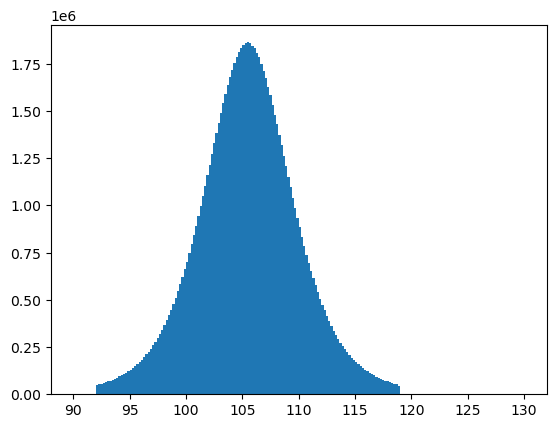

In [57]:
plt.figure()
plt.hist(noise_pixels.flatten(), bins = 200, range = (90, 130))
plt.show()

Fits (GNU Astronomy Utilities) 0.21
Run on Sun Jul 14 12:06:00 2024
-----
HDU (extension) information: '/home/aellien/Euclid_ERO/data/Euclid-NISP-Stack-ERO-Abell2390.DR3/Euclid-NISP-H-ERO-Abell2390-LSB.DR3.masked.rot.crop.warp.fits'.
 Column 1: Index (counting from 0, usable with '--hdu').
 Column 2: Name ('EXTNAME' in FITS standard, usable with '--hdu').
 Column 3: Image data type or 'table' format (ASCII or binary).
 Column 4: Size of data in HDU.
 Column 5: Units of data in HDU (only images, for tables use 'asttable -i').
           ('n/a': no unit in HDU metadata, or HDU is a table)
-----
0      WARP-CONFIG     no-data         0         n/a
1      Warped          float32         2251x2251 n/a


CompletedProcess(args=['astfits', '/home/aellien/Euclid_ERO/data/Euclid-NISP-Stack-ERO-Abell2390.DR3/Euclid-NISP-H-ERO-Abell2390-LSB.DR3.masked.rot.crop.warp.fits'], returncode=0)